# 1. Goals
In this notebook I'll attempt to build models to correctly predict the author of a given article. The scope will be limited to 10 authors. The techniques I'll use will include `Tf-idf` Analysis for feature-generation, and `Supervised Learning` (Keras library) for classification.

# 2. Introduction to DataSet
**From:** [snapcrack/all-the-news](https://www.kaggle.com/snapcrack/all-the-news)

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title.
The original source on [kaggle.com](https://www.kaggle.com) contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications.

# Step 0
### Import required library

In [8]:
# --------- Data processing --------- #
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# --------- Model design --------- #
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential
# --------- Visualization --------- #
from wordcloud import WordCloud
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# Input data files are available in the read-only "../input/" directory
data_path = ['data/articles1.csv',
'data/articles2.csv']

# Step 1
### Exploratory Data Analysis

In [9]:
# Read data into a DataFrame
dataframes = [pd.read_csv(data) for data in data_path]
df = pd.concat(dataframes, ignore_index=True, sort=False)

In [10]:
# Preview the data
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [11]:
# drop useless cloumn
df.drop(['Unnamed: 0', 'url', 'id', 'year', 'month'], axis=1, inplace=True)
# count of missing data
df.isna().sum()

title              1
publication        0
author         14904
date            2626
content            0
dtype: int64

In [12]:
df.dropna(inplace=True) # Drop missing data
df.describe()

,title,publication,author,date,content
count,83417,83417,83417,83417,83417
unique,83092,10,8267,794,82975
top,,Breitbart,Breitbart News,2017-04-13,advertisement
freq,12,23781,1559,313,42


## Limit Data
### Extract authors with the most news

In [19]:
# Top ten author name and sum of news
top_wirter = df.author.value_counts()[:10] 
sum(top_wirter.values)

9262

In [21]:
# Drop rows that are not in the top_writer
df_top = pd.DataFrame(columns=df.columns)
for i in top_wirter.keys():
    df_top = df_top.append(df[df.author == i], ignore_index=True)
df = df_top
del df_top

* look at the histogram of writing of authors

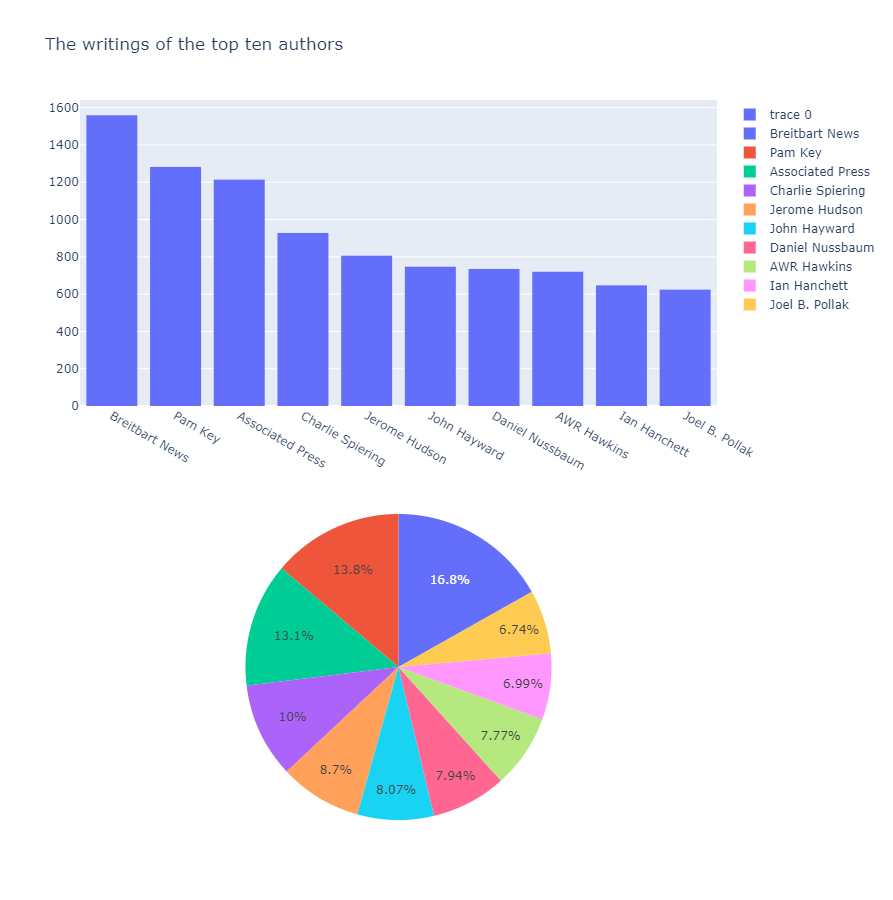

In [20]:
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "histogram"}], [{"type": "pie"}]],
)

x_fig, y_fig = [*df.author.keys()], [*top_wirter.values]

fig.add_trace(
    go.Histogram(histfunc="sum", y=y_fig, x=x_fig),
    
    row=1, col=1
)
    
fig.add_trace(
    go.Pie(labels=x_fig, values=y_fig
),
    row=2, col=1
)

fig.update_layout(height=900, width=900, title_text="The writings of the top ten authors")
fig.show() 

# Step 2
### preprocess data

I use various libraries to perform this cleaning

In [63]:
def process_row(row):
    import re
    from textblob import Word
    from string import punctuation
    from nltk.stem.snowball import SnowballStemmer
    from gensim.parsing.preprocessing import STOPWORDS
    
    
    #Mail address
    row = re.sub('(\S+@\S+)(com|\s+com)', ' ', row)
    #Username
    row = re.sub('(\S+@\S+)', ' ', row)
    #punctuation
    punctuation = punctuation + '\n' + '—“,”‘-’' + '0123456789'
    row = ''.join(word for word in row if word not in punctuation)
    #Lower case 
    row = row.lower()
    #Stopwords
    stop = STOPWORDS
    row = ' '.join(word for word in row.split() if word not in stop)    
    #Lemma
    row = " ".join([Word(word).lemmatize() for word in row.split()])
    #Stemming
    stemmer = SnowballStemmer(language='english')
    row = " ".join([stemmer.stem(word) for word in row.split()])
    #Extra whitespace
    row = re.sub('\s{1,}', ' ', row)
    
    row = " ".join([word for word in row.split() if len(word) > 2])

    return row

In [64]:
df['content'] = df['content'].apply(process_row)

In [79]:
df.to_csv('top_ten_preprocessed.csv')

* build Word cloud for show word With a lot of repetition

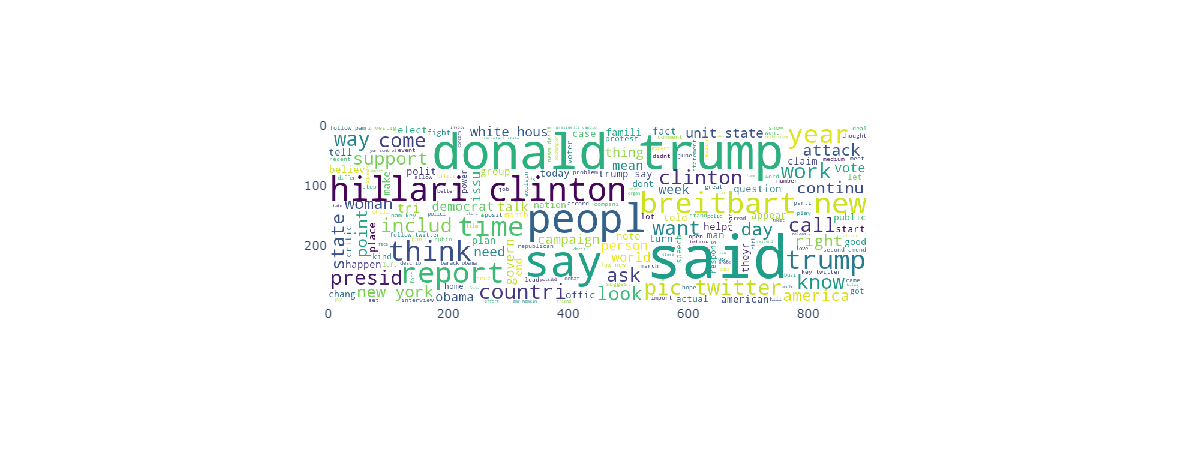

In [65]:
text = ''
for i in df['content'].values:
    text += f'{i}'
wordclud = WordCloud(width=900, height=300, background_color='white').generate(text)
fig = px.imshow(wordclud)
fig.show()

# Step 3
### Convert words to numbers (`tf-idf`: for article, `one-hot`: for labels) to embed in the model

In [81]:
le = LabelEncoder()
labels = to_categorical(le.fit_transform(df.author)) # One-Hot encoding 

In [82]:
corpus = [*df.content.values]
corpus = [c.split() for c in corpus] # add articles in a list

In [83]:
le.classes_

array(['AWR Hawkins', 'Associated Press', 'Breitbart News',
       'Charlie Spiering', 'Daniel Nussbaum', 'Ian Hanchett',
       'Jerome Hudson', 'Joel B. Pollak', 'John Hayward', 'Pam Key'],
      dtype=object)

## What is Tfidf ?
* TFIDF, short for `term frequency–inverse document frequency`, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [85]:
# Tokenize words to tf-idf matrix
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_matrix(corpus, mode='tfidf')

In [87]:
# Divide the data into two categories: train and test
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=.3)

# Step 4
### Create Model

In [89]:
model = keras.Sequential([
    Dense(128,input_shape=(sequences[0].shape)),
    Dropout(.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(.3),
    Dense(64),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

In [90]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 128)          4900480   
_________________________________________________________________
lstm_12 (LSTM)               (None, 150, 128)          131584    
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 5,164,938
Trainable params: 264,458
Non-trainable params: 4,900,480
_________________________________________________________________


In [91]:
es_callback = keras.callbacks.EarlyStopping(patience=3)
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=.2, callbacks=[es_callback])

Epoch 1/10
203/203 [==============================] - 48s 238ms/step - loss: 2.1044 - accuracy: 0.1876 - val_loss: 2.0765 - val_accuracy: 0.2155
Epoch 2/10
203/203 [==============================] - 47s 230ms/step - loss: 2.0215 - accuracy: 0.2326 - val_loss: 2.7670 - val_accuracy: 0.1817
Epoch 3/10
203/203 [==============================] - 46s 229ms/step - loss: 2.0915 - accuracy: 0.1937 - val_loss: 2.1285 - val_accuracy: 0.2105
Epoch 4/10
203/203 [==============================] - 47s 232ms/step - loss: 2.0608 - accuracy: 0.2052 - val_loss: 1.9975 - val_accuracy: 0.2271
Epoch 5/10
203/203 [==============================] - 47s 231ms/step - loss: 1.9304 - accuracy: 0.2667 - val_loss: 1.9024 - val_accuracy: 0.2922
Epoch 6/10
203/203 [==============================] - 46s 229ms/step - loss: 1.7129 - accuracy: 0.3410 - val_loss: 1.6844 - val_accuracy: 0.3660
Epoch 7/10
203/203 [==============================] - 47s 230ms/step - loss: 1.6410 - accuracy: 0.3861 - val_loss: 1.5280 - val_ac

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['val_accuracy'],
                    mode='lines',
                    name='Test acc'))
fig.add_trace(go.Scatter(y=history.history['accuracy'],
                    mode='lines',
                    name='Train acc'))

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['val_loss'],
                    mode='lines',
                    name='Test loss'))
fig.add_trace(go.Scatter(y=history.history['loss'],
                    mode='lines',
                    name='Train loss'))

fig.show()

In [ ]:
eval_ = model.evaluate(X_test, y_test)

In [ ]:
print("Loss: {0:.5}".format(eval_[0]))
print("Accuracy: {0:.2%}".format(eval_[1]))